# Simple NN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')

# Data preparation

In [3]:
data = pd.read_csv('../../data/SamDysch_glucose_2-5-2022.csv', skiprows=[0])
data.index = pd.to_datetime(data['Device Timestamp'], format="%d-%m-%Y %H:%M")

/home/sdysch/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# drop non-historic glucose records
data = data[data['Record Type'] == 0]

# only keep bg
to_keep = [
    'Historic Glucose mmol/L',
]
data = data[to_keep]

data = data.rename(columns={'Historic Glucose mmol/L': 'reading'})

data.head()

,reading
Device Timestamp,
2019-12-09 19:04:00,6.8
2019-12-09 19:20:00,7.6
2019-12-09 19:35:00,7.7
2019-12-09 19:50:00,7.2
2019-12-09 20:05:00,5.8


In [5]:
# drop NaNs
data = data.dropna()

# Setup hypo threshold

In [6]:
HYPO_THRESHOLD = 3.9
data['is_hypo'] = (data['reading'] < HYPO_THRESHOLD).astype(int)

In [7]:
# adding some time variables
data['hour'] = data.index.hour
data['day'] = data.index.dayofweek
data['month'] = data.index.month

# OneHotEncode hours

In [8]:
data = pd.get_dummies(data, prefix='hour', columns=['hour'])
print(data.columns)

Index(['reading', 'is_hypo', 'day', 'month', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


# creating a lagged and rolling variables
* Was I hypo 15 mins ago? 30 mins ago? Etc
* Rolling average of last N readings
* Sign of gradient of last N readings:
    * I.e., is BG rising, falling, or stable?
    
## Lagged features

In [9]:
# create lags
# To ensure that we do not make a lag between periods of sensor non-usage, create a new df with the lagged indices & merge onto original data frame
def create_lag(df, lag):
    tolerance = 15 * lag
    freq = '15min'
    print(f'Creating lag of {tolerance} minutes')
    lagged_copy = df[['reading']].shift(lag, freq=freq)
    lagged_copy.rename(columns={'reading': f'lagged_reading_{lag}'}, inplace=True)
    
    merged = pd.merge_asof(df, lagged_copy, left_index=True, right_index=True, direction='backward', tolerance=pd.Timedelta(minutes=tolerance))
    # merged = pd.merge_asof(copy, lagged_copy, left_index=True, right_index=True, direction='backward')
    return merged

NLAGS = 8
for lag in range(1, NLAGS):
    data = create_lag(data, lag)

Creating lag of 15 minutes
Creating lag of 30 minutes
Creating lag of 45 minutes
Creating lag of 60 minutes
Creating lag of 75 minutes
Creating lag of 90 minutes
Creating lag of 105 minutes


In [10]:
# For ease of variable calculation, drop the nans
data = data.dropna()

In [11]:
# lagged hypo bools
for lag in range(1, NLAGS):
    data[f'is_lagged_hypo_{lag}'] = (data[f'lagged_reading_{lag}'] < HYPO_THRESHOLD).astype(int)

## Rolling features

In [12]:
# simple differences of lags - was reading higher, lower, or stable?
for lag in range(2, NLAGS):
    data[f'diff_{lag}'] = data['lagged_reading_1'] - data[f'lagged_reading_{lag}']

# gradients - how quick is BG changing?
interval = 15
for lag in range(2, NLAGS):
    data[f'rate_{lag}'] = data[f'diff_{lag}'] / (interval * lag)

## train, test, validation split

In [13]:
TRAIN_SPLIT = 0.5
VAL_SPLIT = 0.35
TEST_SPLIT = 0.15

In [14]:
itrain = int(TRAIN_SPLIT * len(data))
ival = int(VAL_SPLIT * len(data))
itest = int(TEST_SPLIT * len(data))

train_data = data.iloc[:itrain]
val_data = data.iloc[itrain:itrain + ival]
test_data = data.iloc[itrain + ival:]

# Variable selection

In [15]:
rates_and_diffs = [f'diff_{v}' for v in range(2, NLAGS)]
rates_and_diffs.extend([f'rate_{v}' for v in range(2, NLAGS)])

# to fairly compare with baseline, drop any historical variables with time delta < 45 mins
vars_to_drop = [
    'month',
    'day',
    'reading',
    'is_lagged_hypo_1',
    'is_lagged_hypo_2',
    'lagged_reading_1',
    'lagged_reading_2',
    
    'is_lagged_hypo_3',
    'is_lagged_hypo_4',
    'is_lagged_hypo_5',
    'is_lagged_hypo_6',
    'is_lagged_hypo_7',
]
vars_to_drop.extend(rates_and_diffs)

train_data = train_data.drop(vars_to_drop, axis='columns')
val_data = val_data.drop(vars_to_drop, axis='columns')
test_data = test_data.drop(vars_to_drop, axis='columns')

print(train_data.columns)
print(val_data.columns)
print(test_data.columns)

Index(['is_hypo', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7'],
      dtype='object')
Index(['is_hypo', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7'],
      dtype='object')
Index(['is_hypo', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hou

In [16]:
target = 'is_hypo'

X_train = train_data.drop([target], axis='columns')
y_train = train_data[target]

X_val = val_data.drop(target, axis='columns')
y_val = val_data[target]

X_test = test_data.drop(target, axis='columns')
y_test = test_data[target]

print(X_train.columns)

Index(['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7'],
      dtype='object')


# class weights

In [17]:
neg = y_train[y_train == 0].count()
pos = y_train[y_train == 1].count()
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
print(weight_for_0, weight_for_1)

0.5309312867003193 8.582431307243963


# scaling variables

In [18]:
columns_to_scale = [
    'lagged_reading_3',
    'lagged_reading_4',
    'lagged_reading_5',
    'lagged_reading_6',
    'lagged_reading_7',
]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# model setup

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, TruePositives, FalseNegatives, TrueNegatives, FalsePositives, BinaryAccuracy, AUC

input_shape = (X_train.shape[1],)
activation = 'relu'
learning_rate = 0.01

optimizer = Adam(learning_rate=learning_rate)

model = Sequential()
model.add(Dense(40, input_shape=input_shape, activation=activation))
model.add(Dropout(0.8))
model.add(Dense(20, activation=activation))
model.add(Dense(10, activation=activation))
model.add(Dense(1, activation='sigmoid'))

METRICS = [
      # TruePositives(name='tp'),
      # FalsePositives(name='fp'),
      # TrueNegatives(name='tn'),
      # FalseNegatives(name='fn'), 
      # BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      # AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=METRICS)

model.summary()

2022-06-26 08:46:10.218360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-26 08:46:10.218387: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1200      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


2022-06-26 08:46:11.240290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-26 08:46:11.240312: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-26 08:46:11.240325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sdysch-Lenovo-IdeaPad-S540-15IML): /proc/driver/nvidia/version does not exist
2022-06-26 08:46:11.240469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# fit model

In [20]:
batch_size = 128
epochs = 200
callbacks = None
class_weight = {
    0: weight_for_0,
    1: weight_for_1,
}
validation_data = (X_val, y_val)

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    validation_data=validation_data,
    class_weight=class_weight,
    callbacks=callbacks,
    epochs=epochs,
    verbose=1,
    shuffle=True,
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-06-26 08:46:11.341057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-26 08:46:11.365253: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099940000 Hz


Epoch 1/200
162/162 [==============================] - 1s 4ms/step - loss: 0.5523 - precision: 0.1331 - recall: 0.7261 - prc: 0.2178 - val_loss: 0.4246 - val_precision: 0.1848 - val_recall: 0.8228 - val_prc: 0.3952
Epoch 2/200
162/162 [==============================] - 0s 2ms/step - loss: 0.4547 - precision: 0.1860 - recall: 0.7935 - prc: 0.3554 - val_loss: 0.4048 - val_precision: 0.1780 - val_recall: 0.8893 - val_prc: 0.4349
Epoch 3/200
162/162 [==============================] - 0s 2ms/step - loss: 0.4057 - precision: 0.2108 - recall: 0.8368 - prc: 0.3984 - val_loss: 0.3271 - val_precision: 0.2115 - val_recall: 0.8773 - val_prc: 0.4494
Epoch 4/200
162/162 [==============================] - 0s 2ms/step - loss: 0.4009 - precision: 0.2085 - recall: 0.8493 - prc: 0.4149 - val_loss: 0.4112 - val_precision: 0.1813 - val_recall: 0.9046 - val_prc: 0.4574
Epoch 5/200
162/162 [==============================] - 0s 2ms/step - loss: 0.3909 - precision: 0.2058 - recall: 0.8676 - prc: 0.4079 - val_l

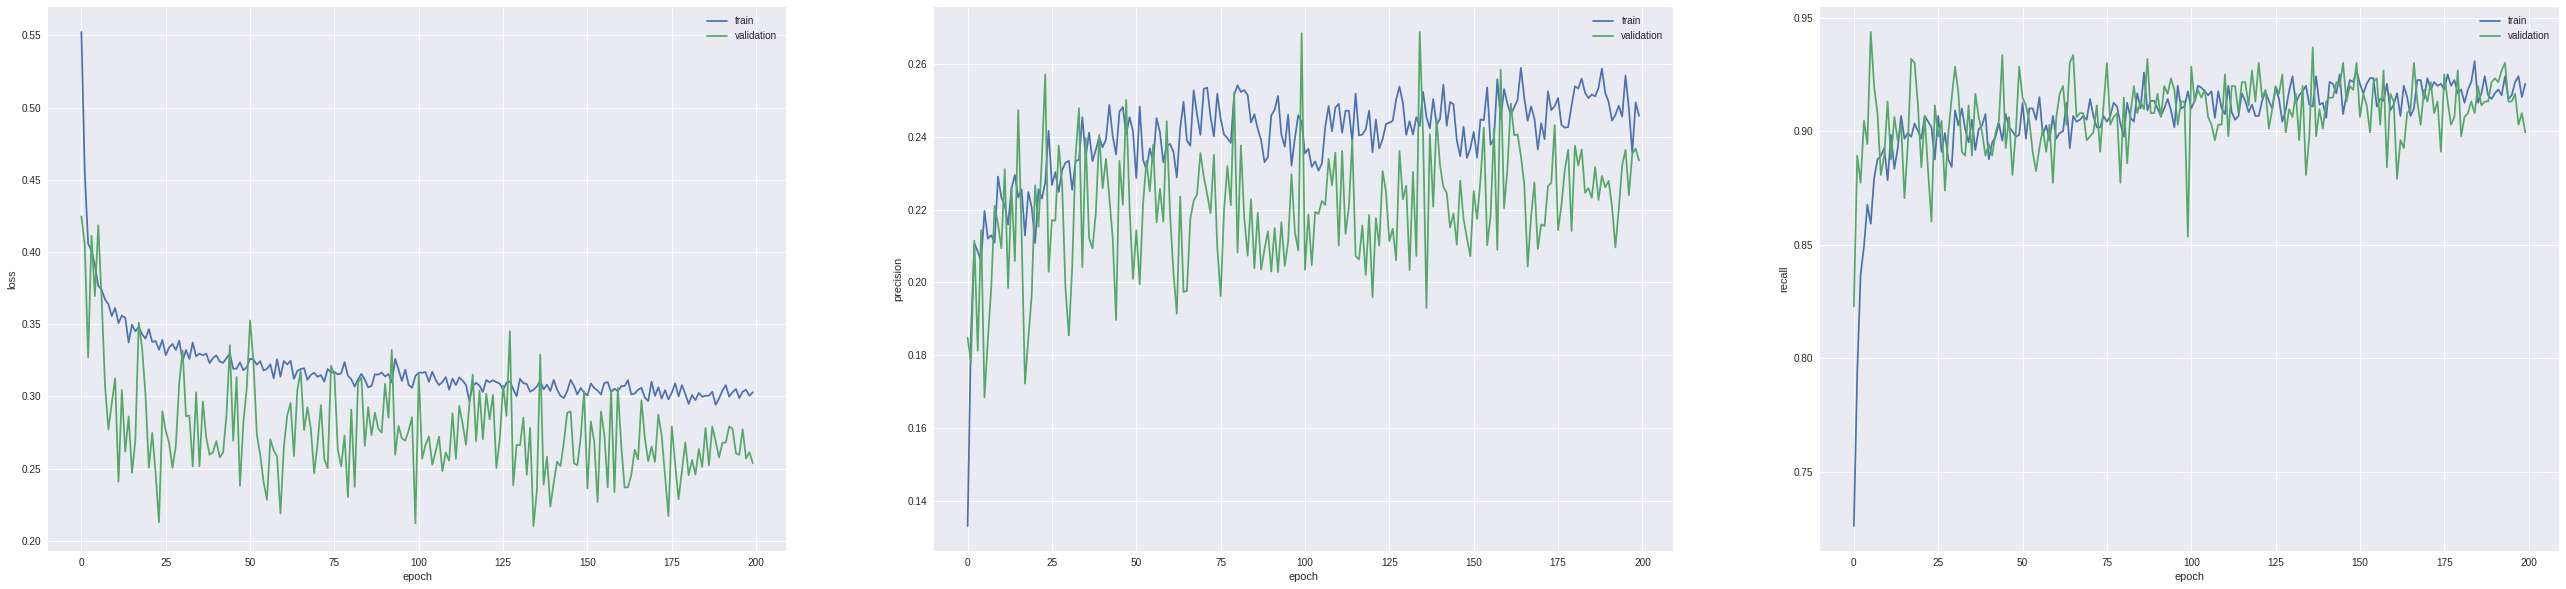

In [21]:
# learning curve
fig, ax = plt.subplots(1, 3, figsize=(45, 10))

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(loc='best')

ax[1].plot(history.history['precision'], label='train')
ax[1].plot(history.history['val_precision'], label='validation')
ax[1].set_ylabel('precision')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='best')

ax[2].plot(history.history['recall'], label='train')
ax[2].plot(history.history['val_recall'], label='validation')
ax[2].set_ylabel('recall')
ax[2].set_xlabel('epoch')
ax[2].legend(loc='best')

In [22]:
'''
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')
print(f'F2: {fbeta_score(y_test, y_pred, beta=2)}')

cm = confusion_matrix(y_test, y_pred, normalize='all')
sns.heatmap(cm, annot=True, square=True)
'''

"\nfrom sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score\ny_pred = model.predict(X_test)\n\nprint(f'Accuracy: {accuracy_score(y_test, y_pred)}')\nprint(f'Precision: {precision_score(y_test, y_pred)}')\nprint(f'Recall: {recall_score(y_test, y_pred)}')\nprint(f'F1: {f1_score(y_test, y_pred)}')\nprint(f'F2: {fbeta_score(y_test, y_pred, beta=2)}')\n\ncm = confusion_matrix(y_test, y_pred, normalize='all')\nsns.heatmap(cm, annot=True, square=True)\n"